# Connecting Kaggle and Google Drive

In [71]:
!pip install -q kaggle

In [72]:
from google.colab import files
from google.colab import drive
#drive.mount("/content/gdrive")

In [73]:
files.upload()

{}

In [74]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [75]:
! cp kaggle.json ~/.kaggle/

In [76]:
! chmod 600 ~/.kaggle/kaggle.json

In [77]:
!kaggle datasets download -d gpiosenka/100-bird-species/

100-bird-species.zip: Skipping, found more recently modified local copy (use --force to force download)


In [78]:
!unzip 100-bird-species.zip;

Archive:  100-bird-species.zip
replace EfficientNetB0-525-(224 X 224)- 98.97.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Importing Libraries

In [79]:
import os
import cv2
import time
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from pathlib import Path
import seaborn as sns
#PYTORCH IMPORTS
import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
#SCI-KIT LEARN IMPORTS
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

DIR_TRAIN = "/content/train/"
DIR_VALID = "/content/valid/"
DIR_TEST = "/content/test/"

# Understanding Data and Data Preprocessing

In [80]:
train_imgs = []
valid_imgs = []
test_imgs = []
classes = os.listdir(DIR_TRAIN)
print("Total Classes:", len(classes))
for _class in classes:
    train_dir = os.path.join(DIR_TRAIN, _class)
    valid_dir = os.path.join(DIR_VALID, _class)
    test_dir = os.path.join(DIR_TEST, _class)

    if os.path.isdir(train_dir):
        for img in os.listdir(train_dir):
            train_imgs.append(os.path.join(train_dir, img))
    else:
        None

    if os.path.isdir(valid_dir):
        for img in os.listdir(valid_dir):
            valid_imgs.append(os.path.join(valid_dir, img))
    else:
        None

    if os.path.isdir(test_dir):
        for img in os.listdir(test_dir):
            test_imgs.append(os.path.join(test_dir, img))
    else:
        None

class_to_int = {classes[i] : i for i in range(len(classes))}

print(f"Total train images: {len(train_imgs)}")
print(f"Total valid images: {len(valid_imgs)}")
print(f"Total test images: {len(test_imgs)}")

Total Classes: 525
Total train images: 84635
Total valid images: 2620
Total test images: 2625


In [81]:
import os
import cv2
import random
def get_top_species(dataset_dir, num_species):
    species_count = {}
    for species in os.listdir(dataset_dir):
        species_dir = os.path.join(dataset_dir, species)
        if os.path.isdir(species_dir):
            species_count[species] = len(os.listdir(species_dir))
    top_species = sorted(species_count, key=species_count.get, reverse=True)[:num_species]
    return top_species

def process_and_save_images(dataset_dir, train_dir, valid_dir, test_dir, top_species, num_images_per_species, is_grayscale=True):
    for save_dir in [train_dir, valid_dir, test_dir]:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    for species in top_species:
        species_dir = os.path.join(dataset_dir, species)
        all_images = os.listdir(species_dir)
        random.shuffle(all_images)

        train_images = all_images[:num_images_per_species]
        remaining_images = all_images[num_images_per_species:]
        split_point = len(remaining_images) // 2
        valid_images = remaining_images[:split_point]
        test_images = remaining_images[split_point:]

        for img_set, save_dir in zip([train_images, valid_images, test_images], [train_dir, valid_dir, test_dir]):
            species_save_dir = os.path.join(save_dir, species)
            if not os.path.exists(species_save_dir):
                os.makedirs(species_save_dir)

            for img_name in img_set:
                img_path = os.path.join(species_dir, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if is_grayscale else cv2.IMREAD_COLOR)
                save_path = os.path.join(species_save_dir, img_name)
                cv2.imwrite(save_path, img)

num_species = 10
num_images_per_species = 100  # Number of images per species for training
top_species = get_top_species('/content/train', num_species)

process_and_save_images('/content/train', '/content/gray_train','/content/gray_valid','/content/gray_test', top_species, num_images_per_species, is_grayscale=True)
process_and_save_images('/content/train', '/content/RGB_train', '/content/RGB_valid','/content/RGB_test',top_species, num_images_per_species, is_grayscale=False)

KeyboardInterrupt: ignored

In [ ]:
num_of_bird_groups = len(os.listdir("/content/gray_train"))
num_of_bird_groups

# Data Augmentation

In [ ]:
#DATA AUGMENTATION
# Augment images and save them to the disk
# Define the augmentation pipelines

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

valid_test_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

def augment_and_save_images(dataset_dir, save_dir, transform, multiply_factor):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for species in os.listdir(dataset_dir):
        species_dir = os.path.join(dataset_dir, species)
        species_save_dir = os.path.join(save_dir, species)
        if not os.path.exists(species_save_dir):
            os.makedirs(species_save_dir)

        for img_name in os.listdir(species_dir):
            img_path = os.path.join(species_dir, img_name)
            image = Image.open(img_path)

            for i in range(multiply_factor):
                img_tensor = transform(image)
                augmented_img = transforms.ToPILImage()(img_tensor)
                augmented_img.save(os.path.join(species_save_dir, f"{i}_{img_name}"))

augment_and_save_images("/content/RGB_train", "/content/aug_RGB_train", train_transforms, 5)
augment_and_save_images("/content/RGB_valid", "/content/aug_RGB_valid", valid_test_transforms, 5)
augment_and_save_images("/content/RGB_test", "/content/aug_RGB_test", valid_test_transforms, 5)
augment_and_save_images("/content/gray_train", "/content/aug_gray_train", train_transforms, 5)
augment_and_save_images("/content/gray_valid", "/content/aug_gray_valid", valid_test_transforms, 5)
augment_and_save_images("/content/gray_test", "/content/aug_gray_test", valid_test_transforms, 5)

In [ ]:
train_imgs = []
valid_imgs = []
test_imgs = []
classes = os.listdir("/content/RGB_train")
print("Total Classes:", len(classes))
for _class in classes:
    train_dir = os.path.join("/content/RGB_train", _class)
    valid_dir = os.path.join("/content/RGB_valid", _class)
    test_dir = os.path.join("/content/RGB_test", _class)

    if os.path.isdir(train_dir):
        for img in os.listdir(train_dir):
            train_imgs.append(os.path.join(train_dir, img))
    else:
        print(f"Warning: Training directory does not exist: {train_dir}")

    if os.path.isdir(valid_dir):
        for img in os.listdir(valid_dir):
            valid_imgs.append(os.path.join(valid_dir, img))
    else:
        print(f"Warning: Validation directory does not exist: {valid_dir}")

    if os.path.isdir(test_dir):
        for img in os.listdir(test_dir):
            test_imgs.append(os.path.join(test_dir, img))
    else:
        print(f"Warning: Test directory does not exist: {test_dir}")

class_to_int = {classes[i] : i for i in range(len(classes))}

print(f"Total train images: {len(train_imgs)}")
print(f"Total valid images: {len(valid_imgs)}")
print(f"Total test images: {len(test_imgs)}")

In [ ]:
train_imgs = []
valid_imgs = []
test_imgs = []
classes = os.listdir("/content/RGB_train")
print("Total Classes:", len(classes))
for _class in classes:
    train_dir = os.path.join("/content/aug_RGB_train", _class)
    valid_dir = os.path.join("/content/aug_RGB_valid", _class)
    test_dir = os.path.join("/content/aug_RGB_test", _class)

    if os.path.isdir(train_dir):
        for img in os.listdir(train_dir):
            train_imgs.append(os.path.join(train_dir, img))
    else:
        print(f"Warning: Training directory does not exist: {train_dir}")

    if os.path.isdir(valid_dir):
        for img in os.listdir(valid_dir):
            valid_imgs.append(os.path.join(valid_dir, img))
    else:
        print(f"Warning: Validation directory does not exist: {valid_dir}")

    if os.path.isdir(test_dir):
        for img in os.listdir(test_dir):
            test_imgs.append(os.path.join(test_dir, img))
    else:
        print(f"Warning: Test directory does not exist: {test_dir}")

class_to_int = {classes[i] : i for i in range(len(classes))}

print(f"Total train images: {len(train_imgs)}")
print(f"Total valid images: {len(valid_imgs)}")
print(f"Total test images: {len(test_imgs)}")

# Machine Learning Methods

In [ ]:
def prepare_data_and_labels(directory, species_list,img_size=(64,64)):
    data = []
    labels = []
    for label, bird in enumerate(species_list):
        bird_dir = os.path.join(directory, bird)
        for image in os.listdir(bird_dir):
            img_path = os.path.join(bird_dir, image)
            img = Image.open(img_path).resize(img_size)
            img_array = np.array(img).flatten()
            data.append(img_array)
            labels.append(label)
    return np.array(data), np.array(labels)

# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

# Train Random Forest Classifier
rf_classifier_augrgb = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_augrgb.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_augrgb.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

In these models, we have chosen the best parameters based on the validation set, and reported the test accuracy on the test set at the end.





Training with RGB images

# Random Forest

In [ ]:
X_train, y_train = prepare_data_and_labels("/content/aug_RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

# Train Random Forest Classifier
rf_classifier_rgb = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_rgb.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_rgb.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

Training with Gray images

In [ ]:
X_train, y_train = prepare_data_and_labels("/content/gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

# Train Random Forest Classifier
rf_classifier_gray = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_gray.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_gray.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

Training with Augmented Gray images

In [ ]:
X_train, y_train = prepare_data_and_labels("/content/aug_gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

# Train Random Forest Classifier
rf_classifier_auggray = RandomForestClassifier(n_estimators=10, random_state=464)
rf_classifier_auggray.fit(X_train, y_train)

# Evaluate the Random Forest classifier
y_pred_rf = rf_classifier_auggray.predict(X_test)
print("Random Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix,annot=True)

# Multinomial Logistic Regression

In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix,annot=True)

In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/aug_RGB_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix,annot=True)

In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix,annot=True)

In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/aug_gray_train", top_species)
X_test, y_test = prepare_data_and_labels("/content/gray_test", top_species)

logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logistic_regression_classifier.fit(X_train, y_train)

y_pred_lr = logistic_regression_classifier.predict(X_test)
print("Multinomial Logistic Regression Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix,annot=True)

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

## Apply PCA and compare results

In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species,img_size=(224,224))
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species,img_size=(224,224))

pca = PCA(n_components=0.90)
scaler = StandardScaler()
logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=464, max_iter=100)

pipeline = make_pipeline(scaler, pca, logistic_regression_classifier)

pipeline.fit(X_train, y_train)

y_pred_lr = pipeline.predict(X_test)
print("Multinomial Logistic Regression Classifier with PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/RGB_train", top_species,img_size=(224,224))
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species,img_size=(224,224))

pca = PCA(n_components=0.80)
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=464)

pipeline = make_pipeline(scaler, pca, rf_classifier)

pipeline.fit(X_train, y_train)

y_pred_rf = pipeline.predict(X_test)
print("Random Forest Classifier with PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

In [ ]:
# Prepare data and labels
X_train, y_train = prepare_data_and_labels("/content/aug_RGB_train", top_species,img_size=(224,224))
X_test, y_test = prepare_data_and_labels("/content/RGB_test", top_species,img_size=(224,224))

pca = PCA(n_components=0.90)
scaler = StandardScaler()
logistic_regression_classifier = LogisticRegression(solver='saga', multi_class='multinomial', random_state=42, max_iter=100)

pipeline = make_pipeline(scaler, pca, logistic_regression_classifier)

pipeline.fit(X_train, y_train)

y_pred_lr = pipeline.predict(X_test)
print("Multinomial Logistic Regression Classifier with PCA:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


# CNN Model

Initializing the dataset.

In [ ]:
class BirdDataset(Dataset):
    def __init__(self, root_dir):
        class_names = ["ASIAN GREEN BEE EATER","CASPIAN TERN", "D-ARNAUDS BARBET","HOUSE FINCH","OVENBIRD","RED BILLED TROPICBIRD","RUFOUS TREPE","SWINHOES PHEASANT","WOOD DUCK","WOOD THRUSH"]
        self.class_list = []
        self.image_path_list = []

        for class_id, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)
            image_files = os.listdir(class_dir)
            image_paths = [os.path.join(class_dir, image_file) for image_file in image_files]
            self.image_path_list.extend(image_paths)
            self.class_list.extend([class_id]*len(image_paths))

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, data_id):
        image_path = self.image_path_list[data_id]
        image_class = self.class_list[data_id]
        image = Image.open(image_path)
        image_tensor = self.transform(image)
        return image_class, image_tensor

In [ ]:
train_dataset = BirdDataset(root_dir='/content/aug_RGB_train')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = BirdDataset(root_dir='/content/RGB_valid')
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = BirdDataset(root_dir='/content/RGB_test')
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
random.seed(464)

In [ ]:
#MODEL 1
import torch.nn as nn
import torch.nn.functional as F

class BirdCNN(nn.Module):
    def __init__(self):
        super(BirdCNN, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=64*28*28, out_features=128),
            nn.ReLU(),
            #nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv_block_1(x)  # Bx3x224x224 --> Bx16x112x112
        x = self.conv_block_2(x)  # Bx16x112x112 --> Bx32x56x56
        x = self.conv_block_3(x)  # Bx32x56x56 --> Bx64x28x28
        x = self.flatten(x)       # Bx64x28x28 --> Bx50176
        x = self.fc_layers(x)     # Bx50176 --> Bx128 --> Bx64 --> Bx10
        x = self.sigmoid(x)
        return x


In [ ]:
#MODEL 2
import torch.nn as nn
import torch.nn.functional as F

class AlternativeBirdCNN(nn.Module):
    def __init__(self):
        super(AlternativeBirdCNN, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256 * 14 * 14, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        x = self.softmax(x)
        return x

In [ ]:
#MODEL 3

import torch.nn as nn
import torch.nn.functional as F

class ModifiedBirdCNN(nn.Module):
    def __init__(self):
        super(ModifiedBirdCNN, self).__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Global Average Pooling
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=10)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)

        # Global Average Pooling
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)

        x = self.fc_layers(x)
        return x



In [ ]:
# Check if a GPU is available and move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedBirdCNN().to(device)
loss_func = nn.CrossEntropyLoss()

learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model = ModifiedBirdCNN()  # Instantiate the improved model

loss_func = nn.CrossEntropyLoss()  # CrossEntropyLoss is appropriate for multi-class classification
learning_rate = 2e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
#TRAINING WITH LOCAL GPU

from tqdm import tqdm

# Modify the data loading to move batches to the same device as the model
num_batches = len(train_dataloader)
num_epochs = 15
iter_losses = []
epoch_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress", total=num_epochs, position=0, leave=True):
    total_iter_loss = 0.0
    for image_class_batch, image_tensor_batch in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):
        # Move data to the same device as the model
        image_tensor_batch, image_class_batch = image_tensor_batch.to(device), image_class_batch.to(device)

        optimizer.zero_grad()
        batch_output = model(image_tensor_batch)
        loss = loss_func(batch_output, image_class_batch)
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        total_iter_loss += loss.item()
    epoch_loss = total_iter_loss / num_batches
    epoch_losses.append(epoch_loss)
    print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")

print("Training is finished!")

In [ ]:
from tqdm import tqdm

num_batches = len(train_dataloader)
num_epochs = 15
iter_losses = []
epoch_losses = []

for epoch in tqdm(range(num_epochs), desc="Training Progress", total=num_epochs, position=0, leave=True):
    total_iter_loss = 0.0
    for image_class_batch, image_tensor_batch in tqdm(train_dataloader, desc=f"Epoch: {epoch+1}", total=num_batches, position=0, leave=True):
        optimizer.zero_grad()
        batch_output = model(image_tensor_batch)
        loss = loss_func(batch_output, image_class_batch)
        loss.backward()
        optimizer.step()

        iter_losses.append(loss.item())
        total_iter_loss += loss.item()
    epoch_loss = total_iter_loss / num_batches
    epoch_losses.append(epoch_loss)
    print(f"\nEpoch {epoch+1} Loss: {epoch_loss}")

print("Training is finished!")

In [ ]:
plt.plot(range(len(iter_losses)), iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss per Iteration")
plt.show()

In [ ]:
plt.plot(range(len(epoch_losses)), epoch_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.show()

In [ ]:
#EVALUATION IN LOCAL GPU

model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for batch_image_class, batch_image_tensor in val_dataloader:
        # Move data to the same device as the model
        batch_image_tensor, batch_image_class = batch_image_tensor.to(device), batch_image_class.to(device)


        batch_outputs = model(batch_image_tensor)

        # Use torch.argmax instead of np.argmax
        pred_classes = torch.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum().item()

        pred_class_list.extend(list(pred_classes.cpu().numpy()))
        gt_class_list.extend(list(batch_image_class.cpu().numpy()))

    print("Validation Accuracy: {:.2%}".format(num_pred_correct / num_pred_total))

In [ ]:
model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

with torch.no_grad():
    for batch_image_class, batch_image_tensor in val_dataloader:
        batch_outputs = model(batch_image_tensor)

        batch_image_class = batch_image_class.numpy()
        batch_outputs = batch_outputs.cpu().numpy()
        pred_classes = np.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum()

        pred_class_list.extend(list(pred_classes))
        gt_class_list.extend(list(batch_image_class))

    print("Validation Accuracy: {}".format(num_pred_correct / num_pred_total))

In [ ]:
num_classes = 10
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)
for sample_id in range(len(gt_class_list)):
    pred_class = pred_class_list[sample_id]
    gt_class = gt_class_list[sample_id]
    confusion_matrix[gt_class, pred_class] += 1
sns.heatmap(confusion_matrix, annot=True, fmt="d")

In [ ]:
#TEST EVALUATION IN LOCAL GPU

model.eval()

num_pred_correct = 0
num_pred_total = 0
pred_class_list = []
gt_class_list = []

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for batch_image_class, batch_image_tensor in test_dataloader:
        # Move data to the same device as the model
        batch_image_tensor, batch_image_class = batch_image_tensor.to(device), batch_image_class.to(device)


        batch_outputs = model(batch_image_tensor)

        # Use torch.argmax instead of np.argmax
        pred_classes = torch.argmax(batch_outputs, axis=1)

        num_pred_total += len(pred_classes)
        num_pred_correct += (pred_classes == batch_image_class).sum().item()

        pred_class_list.extend(list(pred_classes.cpu().numpy()))
        gt_class_list.extend(list(batch_image_class.cpu().numpy()))

    print("Test Accuracy: {:.2%}".format(num_pred_correct / num_pred_total))

In [ ]:
num_classes = 10
confusion_matrix = np.zeros((num_classes, num_classes), np.int32)
for sample_id in range(len(gt_class_list)):
    pred_class = pred_class_list[sample_id]
    gt_class = gt_class_list[sample_id]
    confusion_matrix[gt_class, pred_class] += 1
sns.heatmap(confusion_matrix, annot=True, fmt="d")

# EfficientNet-B0


In [50]:
def data_generators(train_path, valid_path, test_path, batch_size = 16, target_size = (224, 224)):
  train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
  valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_path,
      target_size = target_size,
      batch_size = batch_size,
      class_mode = "categorical"
  )

  valid_generator = valid_datagen.flow_from_directory(
      valid_path,
      target_size = target_size,
      batch_size = batch_size,
      class_mode = "categorical"
  )

  test_generator = test_datagen.flow_from_directory(
      test_path,
      target_size = target_size,
      batch_size = batch_size,
      class_mode = "categorical",
      shuffle=False
  )
  return train_generator, valid_generator, test_generator



def apply_transfer_learning(base_model, base_model_type, train_path, valid_path, test_path):
  for layer in base_model.layers:
      layer.trainable = False
  checkpoint_cb = ModelCheckpoint(
      'model.h5',  # Path where to save the model
      save_best_only=True,        # Save only the best model
      monitor='val_accuracy',     # Performance metric to monitor
      mode='max',                 # Mode for the monitored metric ('max' for accuracy)
      verbose=1                   # Verbosity level
    )
  early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',    # Performance metric to monitor
    patience=5,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored metric
    verbose=1                  # Verbosity level
  )

  X = base_model.output
  X = GlobalAveragePooling2D()(X)
  if (base_model_type ==  "efficientnetb0"):
    X = Dense(10, activation = "softmax")(X)
    model = Model(inputs = base_model.input, outputs = X) # <- our model to be trained
  elif (base_model_type == "resnet50"):
    X = Dense(1024, activation = "relu")(X) # <- add a fully connected layer
    predictions = Dense(10, activation = "softmax")(X) # <- add a 10-class softmax layer at the end
    model = Model(inputs = base_model.input, outputs = predictions) # <- our model to be trained


  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  train_generator, valid_generator, test_generator = data_generators( train_path, valid_path, test_path)
  history = model.fit(
                      train_generator,
                      epochs = 10,
                      validation_data = valid_generator,
                      callbacks=[checkpoint_cb, early_stopping_cb]
                       )
  test_loss, test_accuracy = model.evaluate(test_generator)
  true_classes = test_generator.classes
  predicted_classes = make_inference(model, test_generator)
  cm = confusion_matrix(true_classes, predicted_classes)
  sns.heatmap(cm, annot = True)
  return history,test_loss, test_accuracy

def plot_history(history, title, data_type, is_aug = False):
  # Plotting training and validation accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  if is_aug:
    plt.title(f"Model accuracy for {title} Model with Augmented {data_type} Data")
  else:
    plt.title(f"Model accuracy for {title} Model with Not Augmented {data_type} Data")

  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  # Plotting training and validation loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  if is_aug:
    plt.title(f"Model loss for {title} Model with Augmented {data_type} Data")
  else:
    plt.title(f"Model loss for {title} Model with Not Augmented {data_type} Data")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()


def make_inference(model, test_generator):

    test_generator.reset()

    # Make predictions
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_classes = np.argmax(predictions, axis=1)
    class_indices = test_generator.class_indices
    predicted_classes = np.argmax(predictions, axis = 1)

    return predicted_classes



In [51]:
from keras.models import load_model

Found 1000 images belonging to 10 classes.
Found 629 images belonging to 10 classes.
Found 634 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.9106 - accuracy: 0.8140
Epoch 1: val_accuracy improved from -inf to 0.95707, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 13s 91ms/step - loss: 0.9106 - accuracy: 0.8140 - val_loss: 0.3073 - val_accuracy: 0.9571
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.2042 - accuracy: 0.9810
Epoch 2: val_accuracy improved from 0.95707 to 0.97615, saving model to model.h5
63/63 [==============================] - 5s 85ms/step - loss: 0.2042 - accuracy: 0.9810 - val_loss: 0.1666 - val_accuracy: 0.9762
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9920
Epoch 3: val_accuracy improved from 0.97615 to 0.97774, saving model to model.h5
63/63 [==============================] - 4s 65ms/step - loss: 0.1170 - accuracy: 0.9920 - val_loss: 0.1222 - val_accuracy: 0.9777
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.0774 - accuracy: 0.9970
Epoch 4: val_accuracy did not improve from 0.97774
63/63 [==============================] - 4s 59ms/step - loss: 0.0774 - accuracy: 0.9970 - val_loss: 0.1017 - val_a

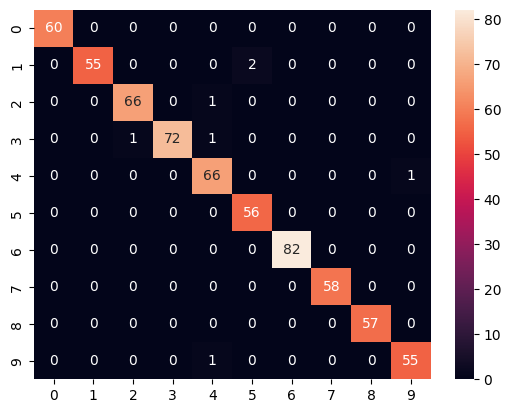

In [52]:
history_rgb, test_loss_rgb, test_accuracy_rgb = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)),
    "efficientnetb0", "/content/RGB_train", "/content/RGB_valid", "/content/RGB_test")


Found 1000 images belonging to 10 classes.
Found 629 images belonging to 10 classes.
Found 634 images belonging to 10 classes.
Epoch 1/10
62/63 [============================>.] - ETA: 0s - loss: 0.9813 - accuracy: 0.7663
Epoch 1: val_accuracy improved from -inf to 0.95231, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 18s 112ms/step - loss: 0.9727 - accuracy: 0.7680 - val_loss: 0.3895 - val_accuracy: 0.9523
Epoch 2/10
62/63 [============================>.] - ETA: 0s - loss: 0.2813 - accuracy: 0.9583
Epoch 2: val_accuracy improved from 0.95231 to 0.96661, saving model to model.h5
63/63 [==============================] - 4s 69ms/step - loss: 0.2794 - accuracy: 0.9580 - val_loss: 0.2230 - val_accuracy: 0.9666
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9820
Epoch 3: val_accuracy did not improve from 0.96661
63/63 [==============================] - 4s 66ms/step - loss: 0.1675 - accuracy: 0.9820 - val_loss: 0.1715 - val_accuracy: 0.9634
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9870
Epoch 4: val_accuracy improved from 0.96661 to 0.97774, saving model to model.h5
63/63 [==============================] - 4s 67ms/step - loss: 0.1213 - accuracy: 0.9870 - val_loss: 0.1387 - val_

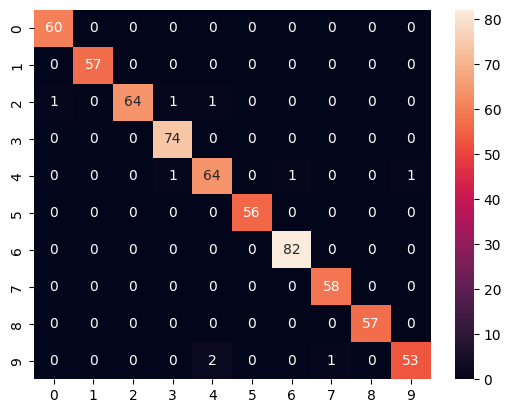

In [59]:
history_gray, test_loss_gray, test_accuracy_gray = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)), "efficientnetb0", "/content/gray_train", "/content/gray_valid", "/content/gray_test")

Found 5000 images belonging to 10 classes.
Found 3145 images belonging to 10 classes.
Found 3170 images belonging to 10 classes.
Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.3071 - accuracy: 0.9452
Epoch 1: val_accuracy improved from -inf to 0.97424, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 29s 67ms/step - loss: 0.3063 - accuracy: 0.9454 - val_loss: 0.1096 - val_accuracy: 0.9742
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.0457 - accuracy: 0.9970
Epoch 2: val_accuracy improved from 0.97424 to 0.97901, saving model to model.h5
313/313 [==============================] - 20s 63ms/step - loss: 0.0456 - accuracy: 0.9970 - val_loss: 0.0775 - val_accuracy: 0.9790
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9984
Epoch 3: val_accuracy improved from 0.97901 to 0.98092, saving model to model.h5
313/313 [==============================] - 19s 60ms/step - loss: 0.0243 - accuracy: 0.9984 - val_loss: 0.0667 - val_accuracy: 0.9809
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9998
Epoch 4: val_accuracy improved from 0.98092 to 0.98188, saving model to model.h5
313/313 [==============================] - 36s 115ms/step - loss: 0.01

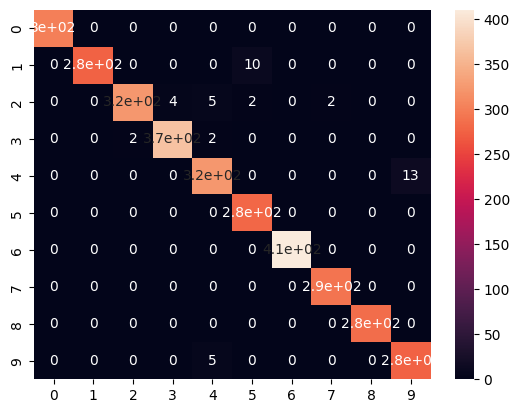

In [60]:
history_rgb_aug, test_loss_rgb_aug, test_accuracy_rgb_aug = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)), "efficientnetb0", "/content/aug_RGB_train", "/content/aug_RGB_valid", "/content/aug_RGB_test")

Found 5000 images belonging to 10 classes.
Found 3145 images belonging to 10 classes.
Found 3170 images belonging to 10 classes.
Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.4180 - accuracy: 0.9161
Epoch 1: val_accuracy improved from -inf to 0.95803, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 29s 66ms/step - loss: 0.4170 - accuracy: 0.9164 - val_loss: 0.1843 - val_accuracy: 0.9580
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9902
Epoch 2: val_accuracy improved from 0.95803 to 0.96566, saving model to model.h5
313/313 [==============================] - 19s 60ms/step - loss: 0.0876 - accuracy: 0.9902 - val_loss: 0.1355 - val_accuracy: 0.9657
Epoch 3/10
312/313 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9954
Epoch 3: val_accuracy improved from 0.96566 to 0.96725, saving model to model.h5
313/313 [==============================] - 19s 60ms/step - loss: 0.0483 - accuracy: 0.9954 - val_loss: 0.1193 - val_accuracy: 0.9672
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9982
Epoch 4: val_accuracy improved from 0.96725 to 0.97011, saving model to model.h5
313/313 [==============================] - 19s 60ms/step - loss: 0.031

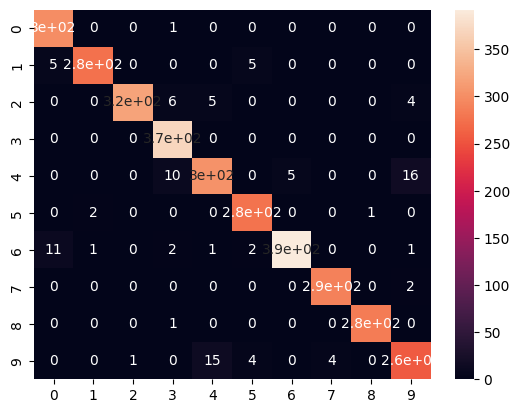

In [61]:
history_gray_aug, test_loss_gray_aug, test_accuracy_gray_aug = apply_transfer_learning( EfficientNetB0(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)), "efficientnetb0", "/content/aug_gray_train", "/content/aug_gray_valid", "/content/aug_gray_test")

In [57]:
print(f"Test Accuracy for the EfficientNet-B0 Model with RGB Data {test_accuracy_rgb}")
print(f"Test Accuracy for the EfficientNet-B0 Model with Grayscale Data {test_accuracy_gray}")
print(f"Test Accuracy for the EfficientNet-B0 Model with Augmented RGB Data {test_accuracy_rgb_aug}")
print(f"Test Accuracy for the EfficientNet-B0 Model with Augmented Grayscale Data {test_accuracy_gray_aug}")

Test Accuracy for the EfficientNet-B0 Model with RGB Data 0.988959014415741
Test Accuracy for the EfficientNet-B0 Model with Grayscale Data 0.9794952869415283
Test Accuracy for the EfficientNet-B0 Model with Augmented RGB Data 0.9851735234260559
Test Accuracy for the EfficientNet-B0 Model with Augmented Grayscale Data 0.9700315594673157


# ResNet50

Found 1000 images belonging to 10 classes.
Found 629 images belonging to 10 classes.
Found 634 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.7487 - accuracy: 0.8150
Epoch 1: val_accuracy improved from -inf to 0.92051, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 22s 260ms/step - loss: 0.7487 - accuracy: 0.8150 - val_loss: 0.2844 - val_accuracy: 0.9205
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9860
Epoch 2: val_accuracy improved from 0.92051 to 0.93323, saving model to model.h5
63/63 [==============================] - 9s 135ms/step - loss: 0.0563 - accuracy: 0.9860 - val_loss: 0.2745 - val_accuracy: 0.9332
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0461 - accuracy: 0.9840
Epoch 3: val_accuracy improved from 0.93323 to 0.95390, saving model to model.h5
63/63 [==============================] - 8s 122ms/step - loss: 0.0461 - accuracy: 0.9840 - val_loss: 0.1964 - val_accuracy: 0.9539
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9940
Epoch 4: val_accuracy did not improve from 0.95390
63/63 [==============================] - 6s 102ms/step - loss: 0.0208 - accuracy: 0.9940 - val_loss: 0.1706 - v

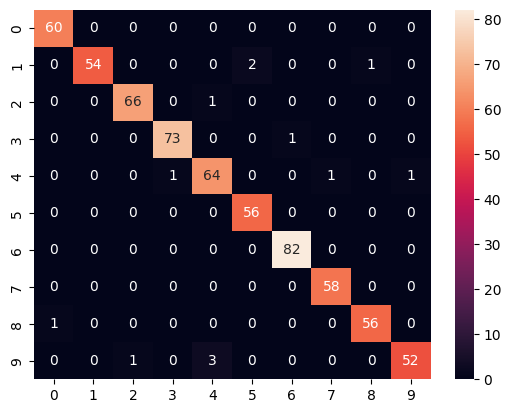

In [65]:
history_rgb, test_loss_rgb, test_accuracy_rgb = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3)),
 "resnet50", "/content/RGB_train", "/content/RGB_valid", "/content/RGB_test")

Found 1000 images belonging to 10 classes.
Found 629 images belonging to 10 classes.
Found 634 images belonging to 10 classes.
Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.7670
Epoch 1: val_accuracy improved from -inf to 0.91574, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 12s 137ms/step - loss: 0.9336 - accuracy: 0.7670 - val_loss: 0.2401 - val_accuracy: 0.9157
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 0.0975 - accuracy: 0.9660
Epoch 2: val_accuracy did not improve from 0.91574
63/63 [==============================] - 6s 98ms/step - loss: 0.0975 - accuracy: 0.9660 - val_loss: 0.2692 - val_accuracy: 0.9046
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.0526 - accuracy: 0.9840
Epoch 3: val_accuracy improved from 0.91574 to 0.92369, saving model to model.h5
63/63 [==============================] - 7s 113ms/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.1901 - val_accuracy: 0.9237
Epoch 4/10
63/63 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9980
Epoch 4: val_accuracy improved from 0.92369 to 0.93482, saving model to model.h5
63/63 [==============================] - 8s 121ms/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 0.2193 - va

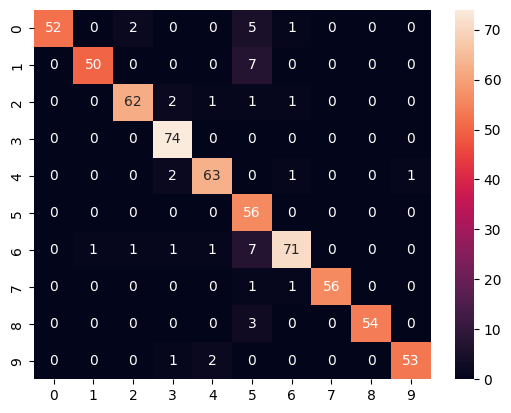

In [67]:
history_gray, test_loss_gray, test_accuracy_gray = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
, "resnet50", "/content/gray_train", "/content/gray_valid", "/content/gray_test")


Found 5000 images belonging to 10 classes.
Found 3145 images belonging to 10 classes.
Found 3170 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9320
Epoch 1: val_accuracy improved from -inf to 0.93800, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 39s 110ms/step - loss: 0.2323 - accuracy: 0.9320 - val_loss: 0.2330 - val_accuracy: 0.9380
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9828
Epoch 2: val_accuracy did not improve from 0.93800
313/313 [==============================] - 40s 129ms/step - loss: 0.0535 - accuracy: 0.9828 - val_loss: 0.3119 - val_accuracy: 0.9332
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0140 - accuracy: 0.9962
Epoch 3: val_accuracy did not improve from 0.93800
313/313 [==============================] - 31s 99ms/step - loss: 0.0140 - accuracy: 0.9962 - val_loss: 0.3380 - val_accuracy: 0.9208
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 0.9992
Epoch 4: val_accuracy improved from 0.93800 to 0.94754, saving model to model.h5
313/313 [==============================] - 32s 101ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.2420 - val_accuracy: 0

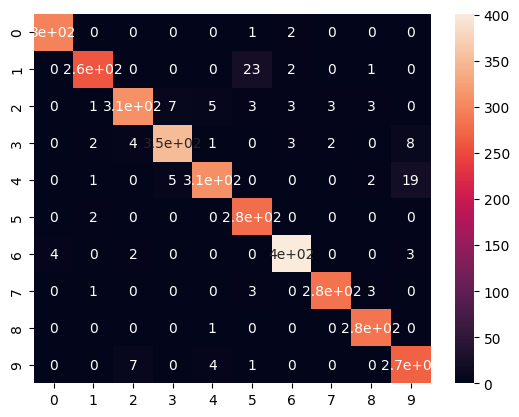

In [68]:
history_rgb_aug, test_loss_rgb_aug, test_accuracy_rgb_aug = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
, "resnet50", "/content/aug_RGB_train", "/content/aug_RGB_valid", "/content/aug_RGB_test")

Found 5000 images belonging to 10 classes.
Found 3145 images belonging to 10 classes.
Found 3170 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 0.3517 - accuracy: 0.8902
Epoch 1: val_accuracy improved from -inf to 0.87440, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


313/313 [==============================] - 36s 105ms/step - loss: 0.3517 - accuracy: 0.8902 - val_loss: 0.4220 - val_accuracy: 0.8744
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9836
Epoch 2: val_accuracy improved from 0.87440 to 0.91955, saving model to model.h5
313/313 [==============================] - 32s 102ms/step - loss: 0.0455 - accuracy: 0.9836 - val_loss: 0.3312 - val_accuracy: 0.9196
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9816
Epoch 3: val_accuracy did not improve from 0.91955
313/313 [==============================] - 31s 99ms/step - loss: 0.0624 - accuracy: 0.9816 - val_loss: 0.3917 - val_accuracy: 0.8992
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9866
Epoch 4: val_accuracy did not improve from 0.91955
313/313 [==============================] - 31s 99ms/step - loss: 0.0392 - accuracy: 0.9866 - val_loss: 0.5841 - val_accuracy: 0.

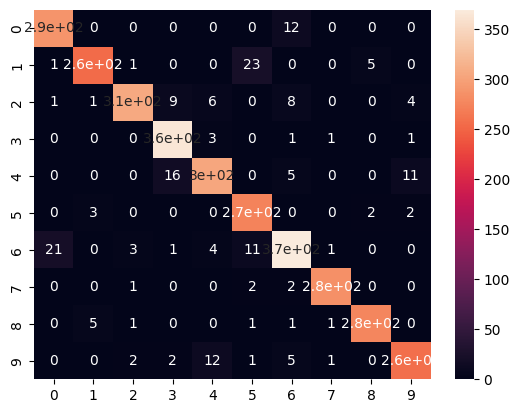

In [69]:
history_gray_aug, test_loss_gray_aug, test_accuracy_gray_aug = apply_transfer_learning( ResNet50(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))
, "resnet50", "/content/aug_gray_train", "/content/aug_gray_valid", "/content/aug_gray_test")

In [70]:
print(f"Test Accuracy for the ResNet50 Model with RGB Data {test_accuracy_rgb}")
print(f"Test Accuracy for the ResNet50 Model with Grayscale Data {test_accuracy_gray}")
print(f"Test Accuracy for the ResNet50 Model with Augmented RGB Data {test_accuracy_rgb_aug}")
print(f"Test Accuracy for the ResNet50 Model with Augmented Grayscale Data {test_accuracy_gray_aug}")

Test Accuracy for the ResNet50 Model with RGB Data 0.9794952869415283
Test Accuracy for the ResNet50 Model with Grayscale Data 0.9321766495704651
Test Accuracy for the ResNet50 Model with Augmented RGB Data 0.9583595991134644
Test Accuracy for the ResNet50 Model with Augmented Grayscale Data 0.9388012886047363
